# Projeto - Previsão de aluguel de bicicletas usando Redes Neurais

Dataset utilizado:

https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Este projeto tem o objetivo de construir uma Rede Neural para prever o rendimento diário de aluguel de bicicletas. 

## Bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.__version__

'1.0.1'

In [3]:
np.__version__

'1.18.1'

In [4]:
import matplotlib
matplotlib.__version__

'3.1.3'

## Carregando e Preparando os Dados

Para se trabalhar com Redes Neurais, preparar os dados é uma das etapas mais importantes. Diferença de escalas nas variáveis dificultam tarefas de otimização e como consequência os pesos podem ser atualizados de forma errada.

In [5]:
# carregar os dados
data_path = 'datasets/hour.csv'
df = pd.read_csv(data_path)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Explorando os Dados

A variável target é o número total de ciclistas `cnt` (`casual` + `registered`).

Cada observação deste dataset corresponde a uma hora de registro.

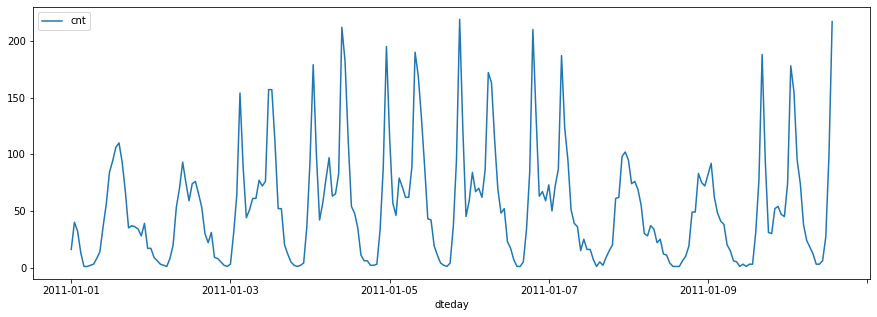

In [6]:
# visualizar os 10 primeiros dias de registros
df[:24*10].plot(x = 'dteday', y = 'cnt', figsize=(15,5));

### Variáveis Dummy

Existem variáveis qualitativas ordinais, onde a distância entre as classes não necessariamente são equivalentes. Para resolver esse problema, é interessante transformá-las em variáveis simuladas binárias.

In [7]:
# array com os nomes das variáveis qualitativas
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

In [8]:
# loop para gerar dummies
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix = each, drop_first = False)
    df = pd.concat([df, dummies], axis = 1)

In [9]:
# excluir colunas
colunas_para_deletar = [
    'instant', 
    'dteday', 
    'season', 
    'weathersit', 
    'weekday', 
    'atemp', 
    'mnth', 
    'workingday', 
    'hr'
]

In [10]:
data = df.drop(colunas_para_deletar, axis = 1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Escalando as Variáveis

Existem algumas maneiras de padronizar as variáveis numéricas para o aprendizado de uma Rede Neural. O método escolhido transforma as variáveis para que tenham média igaual a zero e desvio padrão igual a um.

In [11]:
# separando as variáveis numéricas
features_numericas = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

In [12]:
# loop para média=0 e DP=1
scaled_features = {}
for item in features_numericas:
    mean, std = data[item].mean(), data[item].std()
    scaled_features[item] = [mean, std]
    data.loc[:, item] = (data[item] - mean)/std

### Dividindo os dados em treino, teste e validação

O conjunto de teste serão os últimos 21 dias de dados.

In [15]:
# Salvando os últimos 21 dias
test_data = data[-21*24:]
data = data[:-21*24]

In [16]:
# Separando os dados em variáveis preditoras e variável target
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis = 1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis = 1), test_data[target_fields]

O conjunto de teste ainda será dividido em treino e validação.

In [17]:
# Mantenha os últimos 60 dias dos dados restantes como um conjunto de validação
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Construindo a Rede Neural

Abaixo iremos construir a rede. Vamos configurar o Feed Forward e os hiperparâmetros: a taxa de aprendizado, o número de unidades ocultas e o número de passadas de treinamentos (epochs).

A rede possui duas camadas, uma camada oculta e uma camada de saída. A camada oculta usará a função sigmoid para ativações. A camada de saída tem apenas um nó e é usada para a regressão, a saída do nó é igual à entrada do nó. Ou seja, a função de ativação é $ f (x) = x $. Uma função que recebe o sinal de entrada e gera um sinal de saída, mas leva em consideração o limite (threshold), é chamada de função de ativação. Trabalhamos através de cada camada da nossa rede, calculando as saídas para cada neurônio. Todas as saídas de uma camada tornam-se entradas para os neurônios na próxima camada. Esse processo é chamado de *propagação direta* (Feed Forward).

Usamos os pesos para propagar os sinais para a frente, da entrada para as camadas de saída em uma rede neural. Usamos os pesos para propagar também o erro de trás da saída para a rede para atualizar nossos pesos. Isso é chamado *backpropagation*.

> **Dica:** Você precisará da derivada da função de ativação de saída ($ f (x) = x $) para a implementação de backpropagation. Se você não está familiarizado com o cálculo, esta função é equivalente à equação $ y = x $. Qual é a inclinação dessa equação? Essa é a derivada de $ f (x) $.

In [18]:
# Classe da Rede Neural
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, verbose = False):
        
        # Defina o número de nós nas camadas de entrada, oculta e de saída.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Inicializando os pesos
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        self.verbose = verbose 
        
        if self.verbose:
            print("Rede Neural iniciada com:\ninput_nodes: {}\nhidden_nodes: {}\noutput_nodes: {}\nlearning_rate: {}\n".format(
                self.input_nodes, self.hidden_nodes, self.output_nodes, self.lr
            ))
        
        self.hidden_layer_activation_function = lambda x: 1 / (1 + np.exp(-x))
        self.hidden_layer_derivate_activation_function = lambda sigmoid: sigmoid * (1 - sigmoid)
        self.output_layer_activation_function = lambda x: x 
        self.output_layer_derivate_activation_function = lambda x: 1 
        
        # Ativação
        self.activation_function = self.hidden_layer_activation_function 
    
    def forward_pass(self, inputs):
        
        # Forward pass #
        
        # Sinais da camada de entrada
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        
        # Sinais da camada oculta
        hidden_outputs = self.hidden_layer_activation_function(hidden_inputs) 
        
        # Sinais na camada de saída final
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) 
        final_outputs = self.output_layer_activation_function(final_inputs)
        return [hidden_inputs, hidden_outputs, final_inputs, final_outputs]
    
    def backward_pass(self, inputs, targets, hidden_inputs, hidden_outputs, final_inputs, final_outputs):
        
        # Backward pass #
        output_errors = targets - final_outputs
        output_grad = self.output_layer_derivate_activation_function(final_outputs)
        
        # Backpropagated error
        
        # Erros propagados para a camada oculta
        hidden_errors = output_errors * output_grad * self.weights_hidden_to_output 
        hidden_grad = self.hidden_layer_derivate_activation_function(hidden_outputs)
            
        return [output_errors, hidden_errors, hidden_grad, output_grad]

    def train(self, inputs_list, targets_list):
        
        # Converta a lista de entradas para a matriz 2d
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        hidden_inputs, hidden_outputs, final_inputs, final_outputs = self.forward_pass(inputs)
        output_errors, hidden_errors, hidden_grad, output_grad = self.backward_pass(inputs, targets, hidden_inputs, hidden_outputs, final_inputs, final_outputs)

        # Atualização de pesos para saída com passo de descida de gradiente
        self.weights_hidden_to_output += self.lr * np.dot(output_errors * output_grad, hidden_outputs.T) 
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors.T * hidden_grad, inputs.T)
 
    def run(self, inputs_list):
        # Executa um passo para a frente pela rede
        inputs = np.array(inputs_list, ndmin = 2).T
        
        _, _, _, final_outputs = self.forward_pass(inputs)
        return final_outputs

In [19]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Treinando a Rede

Aqui você configurará os hiperparâmetros da rede. A estratégia é encontrar hiperparâmetros, de modo que o erro no conjunto de treinamento seja baixo, mas você não tenha overfitting. Se você treinar a rede por muito tempo ou tiver muitos nós ocultos, pode tornar-se excessivamente específico para o conjunto de treinamento e não conseguirá generalizar para o conjunto de validação. Ou seja, a perda no conjunto de validação começará a aumentar à medida que a queda do conjunto de treinamento cai.

Você também usará um método conhecido como Descida de Gradiente Estocástica (SGD) para treinar a rede. A idéia é que, para cada passagem de treinamento, você pega uma amostra aleatória dos dados em vez de usar todo o conjunto de dados. Você usa muito mais passagens de treinamento do que com descida de gradiente normal, mas cada passagem é muito mais rápida. Isso acaba treinando a rede de forma mais eficiente. Você aprenderá mais sobre o SGD mais tarde.

### Escolhendo número de epochs
Este é o número de vezes que o conjunto de dados passará pela rede, cada vez que atualizar os pesos. À medida que o número de épocas aumenta, a rede se torna melhor e melhor em prever os alvos no conjunto de treinamento. Você precisará escolher épocas suficientes para treinar a rede bem, mas não demais, ou você terá overfitting.

### Escolhendo a taxa de aprendizagem
Isso reduz o tamanho das atualizações de peso. Se essa taxa for muito grande, os pesos tendem a explodir e a rede não consegue se ajustar aos dados. Uma boa escolha para começar é 0.1. Se a rede tiver problemas ao ajustar os dados, tente reduzir a taxa de aprendizado. Note-se que quanto menor for a taxa de aprendizagem, menores as etapas nas atualizações de peso e quanto maior, demora a convergir a rede neural.

### Escolhendo o número de nodes ocultos
Os nós mais ocultos que você tem, as previsões mais precisas que o modelo fará. Experimente alguns números diferentes e veja como isso afeta o desempenho. Você pode observar o dicionário de perdas para uma métrica da performance da rede. Se o número de unidades escondidas for muito baixo, então o modelo não terá espaço suficiente para aprender e, se for muito alto, há muitas opções para a direção que a aprendizagem pode levar. O truque aqui é encontrar o equilíbrio certo no número de unidades escondidas que você escolher.

In [35]:
import sys

# Configurando os hiperparametros
epochs = 3000
learning_rate = 0.05
hidden_nodes = 30
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate, True)

losses = {'train':[], 'validation':[]}

for e in range(epochs):
    # Percorrer um lote aleatório de 128 registros do conjunto de dados de treinamento
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.iloc[batch].values, 
                              train_targets.iloc[batch]['cnt']):
        network.train(record, target)
    
    # Imprimir o progresso do treinamento
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    
    sys.stdout.write("\rProgresso: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Erro no Treinamento: " + str(train_loss)[:5] \
                     + " ... Erro na Validação: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Rede Neural iniciada com:
input_nodes: 56
hidden_nodes: 30
output_nodes: 1
learning_rate: 0.05

Progresso: 99.9% ... Erro no Treinamento: 0.050 ... Erro na Validação: 0.104

O número de epochs como 3000 é uma boa escolha em si, mas a combinação de hiperparâmetros deve ser ajustada adequadamente. Tente sintonizar todos os hiperparâmetros em paralelo. As perdas de treinamento e validação são aceitáveis. Ao observar o gráfico de perda de treinamento-validação, você não acha que há muito ruído nos dados? Isso pode ser melhorado ajustando corretamente os hiperparâmetros. Tente testar com várias combinações e observe a resposta do modelo. O número de iterações deve ser escolhido para que a perda de treinamento seja baixa e a perda de validação não aumente.

Às vezes, a rede não converge quando a taxa de aprendizado é de 0.1. As etapas de atualização de peso são muito grandes com essa taxa de aprendizado e os pesos acabam por não convergir. Devido à alta taxa de aprendizado, o modelo ignora os pontos mínimos. Ao diminuir a taxa de aprendizagem, você pode obter menor perda de validação e o ruído no gráfico também diminuirá. Tente observar a resposta do modelo para valores como 0.08, 0.05, 0.01, 0.008, etc.

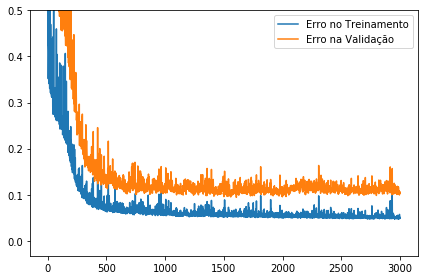

In [36]:
plt.plot(losses['train'], label = 'Erro no Treinamento')
plt.plot(losses['validation'], label = 'Erro na Validação')
plt.legend()
plt.ylim(ymax = 0.5)
plt.tight_layout()

## Fazendo as Previsões

Aqui, usamos os dados do teste para ver como a rede está modelando os dados. Se algo estiver completamente errado, certifique-se de que cada etapa da sua rede esteja implementada corretamente.

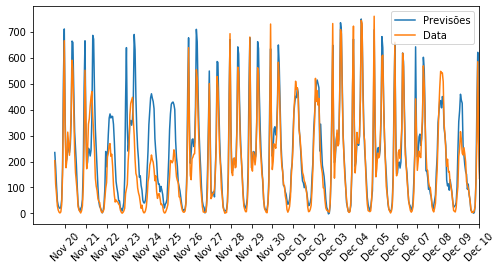

In [37]:
fig, ax = plt.subplots(figsize = (8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label = 'Previsões')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right = len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Avaliando os Resultados
 
Responda estas perguntas sobre seus resultados. Quão bem o modelo prediz os dados? Onde ele falha? Por que ele falha?

> O modelo parece ter resultados bastante decentes, mas a precisão da previsão parece diminuir à medida que avançamos no tempo (a partir de 21 de dezembro). Este fenômeno provavelmente deve-se à existência de variáveis que poderiam ter acontecido entre 21 de dezembro e 31 de dezembro (parece suspeito, pois é o período das celebrações, muitos eventos inesperados podem acontecer durante esse lapso de tempo, o que poderia levar as pessoas a alugar mais bicicletas do que durante um período normal)

# Fim